<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/MedMNIST_QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Snippet 1 (Third User Correction): Data Pipeline with Augmentations

# --- Install ---
!pip install medmnist --quiet

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import medmnist

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Histopathology-Friendly Augmentations ---
aug_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.03),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

eval_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

# --- Data Loading ---
DATASET_NAMES = ['PathMNIST', 'DermaMNIST', 'BloodMNIST']
datasets, dataloaders = {}, {}
print("\n--- Loading Datasets (with Augmentations) ---")

for name in DATASET_NAMES:
    info = medmnist.INFO[name.lower()]
    DataClass = getattr(medmnist, info['python_class'])
    n_channels = info.get('n_channels', 3)

    # Use the appropriate transform for each split
    train_ds = DataClass(split='train', transform=aug_train, download=True)
    val_ds   = DataClass(split='val',   transform=eval_tfm, download=True)
    test_ds  = DataClass(split='test',  transform=eval_tfm, download=True)

    datasets[name] = {'train': train_ds, 'val': val_ds, 'test': test_ds}

    dataloaders[name] = {
        'train': DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True),
        'val':   DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True),
        'test':  DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True),
    }

    print(f"{name}: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}, "
          f"classes={len(train_ds.info['label'])}, channels={n_channels}")

print("\nAll datasets with advanced augmentations are ready.\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.2 MB/s eta 0:00:00
Using device: cpu

--- Loading Datasets (with Augmentations) ---


100%|██████████| 206M/206M [00:25<00:00, 8.13MB/s]


PathMNIST: train=89996, val=10004, test=7180, classes=9, channels=3


100%|██████████| 19.7M/19.7M [00:01<00:00, 13.4MB/s]


DermaMNIST: train=7007, val=1003, test=2005, classes=7, channels=3


100%|██████████| 35.5M/35.5M [00:02<00:00, 17.5MB/s]


BloodMNIST: train=11959, val=1712, test=3421, classes=8, channels=3

All datasets with advanced augmentations are ready.



In [2]:
# Snippet 2 (Third User Correction): The Trainable Quantum Model

# --- Install ---
!pip install pennylane --quiet

import torch
import torch.nn as nn
import pennylane as qml

# --- Trainable QLayer with data re-uploading & dual-basis readout ---
n_qubits = 8
layers = 2  # re-uploading depth
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch', diff_method='backprop')
def trainable_qnode(inputs, theta_rz, theta_ry):
    # inputs: (B, 8) -- TorchLayer handles batching
    # First embedding
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    for l in range(layers):
        # Variational block
        for i in range(n_qubits):
            qml.RZ(theta_rz[l, i], wires=i)
            qml.RY(theta_ry[l, i], wires=i)
        # Ring entanglement
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
        qml.CNOT(wires=[n_qubits-1, 0])

        # Re-upload the same 8 features (gives richer gradients)
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    # Read out in two Pauli bases -> 16 quantum features
    z_feats = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    x_feats = [qml.expval(qml.PauliX(i)) for i in range(n_qubits)]
    return z_feats + x_feats

weight_shapes = {
    "theta_rz": (layers, n_qubits),
    "theta_ry": (layers, n_qubits),
}

class QTFClassifier(nn.Module):
    def __init__(self, q_feature_map, weight_shapes, n_classes=9, in_channels=3):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_qubits)   # -> 8 features
        )

        # Trainable quantum layer (outputs 16-dim: Z and X on 8 qubits)
        self.q_layer = qml.qnn.TorchLayer(q_feature_map, weight_shapes=weight_shapes)

        # Final head now expects 16 inputs
        self.classifier = nn.Sequential(
            nn.Linear(2 * n_qubits, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        feats = self.feature_extractor(x)         # (B, 8), float32
        qfeats = self.q_layer(feats)              # (B, 16)
        qfeats = qfeats.to(feats.dtype)           # keep dtypes consistent
        logits = self.classifier(qfeats)
        return logits

print("Trainable QTF model ready (re-uploading + dual-basis readout).")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 50.8 MB/s eta 0:00:00
Trainable QTF model ready (re-uploading + dual-basis readout).


In [3]:
# Snippet 3 (Third User Correction): The Advanced Training Loop

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

# --- Setup ---
dataset_name = 'PathMNIST'
info = medmnist.INFO[dataset_name.lower()]
in_channels = info.get('n_channels', 3)
n_classes = len(info['label'])

# --- Build Model ---
# This instantiates our final, trainable QTFClassifier
model = QTFClassifier(q_feature_map=trainable_qnode,
                      weight_shapes=weight_shapes,
                      n_classes=n_classes,
                      in_channels=in_channels).to(device)

# --- Optimizer, Loss, and Scheduler ---
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)

# Label smoothing (with a fallback for older torch versions)
try:
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
    print("Using CrossEntropyLoss with label smoothing.")
except TypeError:
    loss_fn = nn.CrossEntropyLoss()
    print("Using standard CrossEntropyLoss (label smoothing not supported).")

# Cosine annealing scheduler for robust convergence
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

# --- DataLoaders ---
train_loader = dataloaders[dataset_name]['train']
val_loader = dataloaders[dataset_name]['val']

def labels_to_indices(y):
    if y.ndim == 2 and y.size(1) > 1:
        return y.argmax(dim=1)
    return y.view(-1).long()

# --- Full Training & Validation Loop ---
num_epochs = 25
best_val = 0.0
print(f"\nStarting final training run on {dataset_name} for {num_epochs} epochs...")

for epoch in range(1, num_epochs + 1):
    # ---- Train ----
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        x = x.to(device, non_blocking=True)
        y = labels_to_indices(y).to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_correct += (logits.argmax(1) == y).sum().item()
        train_total += x.size(0)
    tr_loss = train_loss / train_total
    tr_acc = train_correct / train_total

    # ---- Validate ----
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            x = x.to(device, non_blocking=True)
            y = labels_to_indices(y).to(device, non_blocking=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            val_loss += loss.item() * x.size(0)
            val_correct += (logits.argmax(1) == y).sum().item()
            val_total += x.size(0)
    v_loss = val_loss / val_total
    v_acc = val_correct / val_total

    print(f"Epoch {epoch}: train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} "
          f"val_loss={v_loss:.4f} val_acc={v_acc:.4f}")

    # Step the scheduler
    scheduler.step()

    # Save the best model
    if v_acc > best_val:
        best_val = v_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

print(f"\nTraining complete. Best validation accuracy: {best_val:.4f}")

# Load the best performing model state for our XAI phase
if 'best_state' in locals():
    model.load_state_dict(best_state)
    print("Loaded best model weights. Ready to begin Phase 2: Explainable AI.")

Using CrossEntropyLoss with label smoothing.

Starting final training run on PathMNIST for 25 epochs...


Epoch 1/25 [train]:   0%|          | 0/1407 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/25 [val]: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]


Epoch 1: train_loss=1.7399 train_acc=0.3606 val_loss=1.1961 val_acc=0.5810


Epoch 2/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch 2: train_loss=1.2056 train_acc=0.6029 val_loss=1.3102 val_acc=0.5696


Epoch 3/25 [val]: 100%|██████████| 79/79 [00:16<00:00,  4.91it/s]


Epoch 3: train_loss=1.0478 train_acc=0.6743 val_loss=0.8982 val_acc=0.7365


Epoch 4/25 [val]: 100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


Epoch 4: train_loss=0.9541 train_acc=0.7206 val_loss=0.9753 val_acc=0.7011


Epoch 5/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  5.01it/s]


Epoch 5: train_loss=0.8863 train_acc=0.7528 val_loss=1.1975 val_acc=0.6162


Epoch 6/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  5.02it/s]


Epoch 6: train_loss=0.8390 train_acc=0.7731 val_loss=0.9702 val_acc=0.6978


Epoch 7/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  4.94it/s]


Epoch 7: train_loss=0.8061 train_acc=0.7908 val_loss=0.8268 val_acc=0.7659


Epoch 8/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch 8: train_loss=0.7802 train_acc=0.8017 val_loss=0.6278 val_acc=0.8586


Epoch 9/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.45it/s]


Epoch 9: train_loss=0.7444 train_acc=0.8179 val_loss=0.6545 val_acc=0.8501


Epoch 10/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]


Epoch 10: train_loss=0.7218 train_acc=0.8279 val_loss=0.6911 val_acc=0.8277


Epoch 11/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.41it/s]


Epoch 11: train_loss=0.7015 train_acc=0.8369 val_loss=0.6257 val_acc=0.8640


Epoch 12/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.57it/s]


Epoch 12: train_loss=0.6803 train_acc=0.8459 val_loss=0.6128 val_acc=0.8693


Epoch 13/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.54it/s]


Epoch 13: train_loss=0.6614 train_acc=0.8540 val_loss=0.8272 val_acc=0.7891


Epoch 14/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.45it/s]


Epoch 14: train_loss=0.6472 train_acc=0.8605 val_loss=0.6129 val_acc=0.8680


Epoch 15/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Epoch 15: train_loss=0.6304 train_acc=0.8660 val_loss=0.5246 val_acc=0.9031


Epoch 16/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]


Epoch 16: train_loss=0.6176 train_acc=0.8719 val_loss=0.6211 val_acc=0.8629


Epoch 17/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]


Epoch 17: train_loss=0.6063 train_acc=0.8771 val_loss=0.5501 val_acc=0.8938


Epoch 18/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  5.01it/s]


Epoch 18: train_loss=0.5933 train_acc=0.8820 val_loss=0.5735 val_acc=0.8846


Epoch 19/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Epoch 19: train_loss=0.5849 train_acc=0.8850 val_loss=0.5177 val_acc=0.9072


Epoch 20/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]


Epoch 20: train_loss=0.5746 train_acc=0.8902 val_loss=0.5269 val_acc=0.9060


Epoch 21/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  5.02it/s]


Epoch 21: train_loss=0.5632 train_acc=0.8948 val_loss=0.4919 val_acc=0.9192


Epoch 22/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


Epoch 22: train_loss=0.5590 train_acc=0.8966 val_loss=0.5112 val_acc=0.9137


Epoch 23/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s]


Epoch 23: train_loss=0.5520 train_acc=0.8991 val_loss=0.4992 val_acc=0.9151


Epoch 24/25 [val]: 100%|██████████| 79/79 [00:15<00:00,  5.09it/s]


Epoch 24: train_loss=0.5488 train_acc=0.9006 val_loss=0.5054 val_acc=0.9145


Epoch 25/25 [val]: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]

Epoch 25: train_loss=0.5460 train_acc=0.9010 val_loss=0.4935 val_acc=0.9196

Training complete. Best validation accuracy: 0.9196
Loaded best model weights. Ready to begin Phase 2: Explainable AI.


Found a correctly classified sample.
  True Label: 8 (colorectal adenocarcinoma epithelium)
  Predicted Label: 8 (colorectal adenocarcinoma epithelium)
  Prediction Confidence: 0.8709


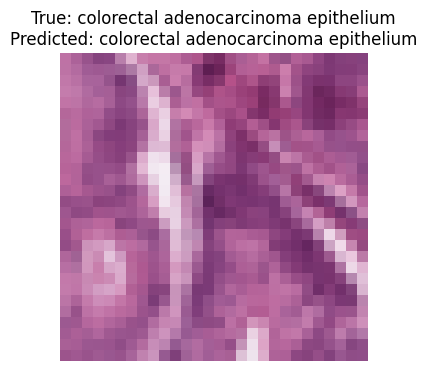

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode and on the correct device
model.eval()
model.to(device)

# --- 1. Select a Sample from the Test Set ---
dataset_name = 'PathMNIST'
test_loader = dataloaders[dataset_name]['test']
info = medmnist.INFO[dataset_name.lower()]
class_names = info['label']

# Let's find a correctly classified image to analyze
found_sample = False
while not found_sample:
    for images, labels in test_loader:
        image_to_test = images[0].unsqueeze(0).to(device) # Get the first image in the batch
        true_label_idx = labels_to_indices(labels)[0].item()

        # Get the model's prediction
        with torch.no_grad():
            logits = model(image_to_test)
            pred_prob = torch.softmax(logits, dim=1)
            pred_label_idx = torch.argmax(pred_prob, dim=1).item()

        # Check if the prediction was correct
        if pred_label_idx == true_label_idx:
            found_sample = True
            break

print("Found a correctly classified sample.")
print(f"  True Label: {true_label_idx} ({class_names[str(true_label_idx)]})")
print(f"  Predicted Label: {pred_label_idx} ({class_names[str(pred_label_idx)]})")
print(f"  Prediction Confidence: {pred_prob.max().item():.4f}")


# --- 2. Visualize the Sample Image ---
# We need to un-normalize the image for proper visualization
# The normalization was transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
# So, un-normalize is: image * std + mean
un_normalized_img = image_to_test.squeeze().cpu().numpy().transpose(1, 2, 0) # From (C, H, W) to (H, W, C)
un_normalized_img = un_normalized_img * 0.5 + 0.5 # Un-normalize
un_normalized_img = np.clip(un_normalized_img, 0, 1) # Clip values to be between 0 and 1

plt.figure(figsize=(4, 4))
plt.imshow(un_normalized_img)
plt.title(f"True: {class_names[str(true_label_idx)]}\nPredicted: {class_names[str(pred_label_idx)]}")
plt.axis('off')
plt.show()

In [5]:
# Snippet 5: Saliency Map Generation

# --- 1. Enable Gradient Calculation on the Input Image ---
# We need to clone the image tensor and set requires_grad=True
image_to_explain = image_to_test.clone().detach().requires_grad_(True)

# --- 2. Perform a Forward Pass ---
# Get the logits from the model
logits = model(image_to_explain)
# The predicted label index is the same as we found in the previous step
# pred_label_idx = torch.argmax(logits, dim=1).item() # This is 8 in our case

# --- 3. Target the Score for the Predicted Class ---
# We select the logit score corresponding to the predicted class
score_for_predicted_class = logits[0, pred_label_idx]

# --- 4. Perform a Backward Pass ---
# Zero out any previous gradients
model.zero_grad()

# Calculate the gradients of the target score with respect to the model's inputs
score_for_predicted_class.backward()

# --- 5. Extract the Saliency Map ---
# The gradients are now stored in the .grad attribute of our input tensor
# We take the absolute value of the gradients
saliency_map_raw = image_to_explain.grad.data.abs()

# To get a single saliency value per pixel, we take the maximum value across the color channels
saliency_map, _ = torch.max(saliency_map_raw, dim=1) # Squeeze the channel dimension
saliency_map = saliency_map.squeeze().cpu().numpy()

print("Saliency map generated successfully.")
print(f"Shape of the saliency map: {saliency_map.shape}")
print(f"Min saliency value: {saliency_map.min():.4f}")
print(f"Max saliency value: {saliency_map.max():.4f}")

Saliency map generated successfully.
Shape of the saliency map: (28, 28)
Min saliency value: 0.0052
Max saliency value: 2.0204


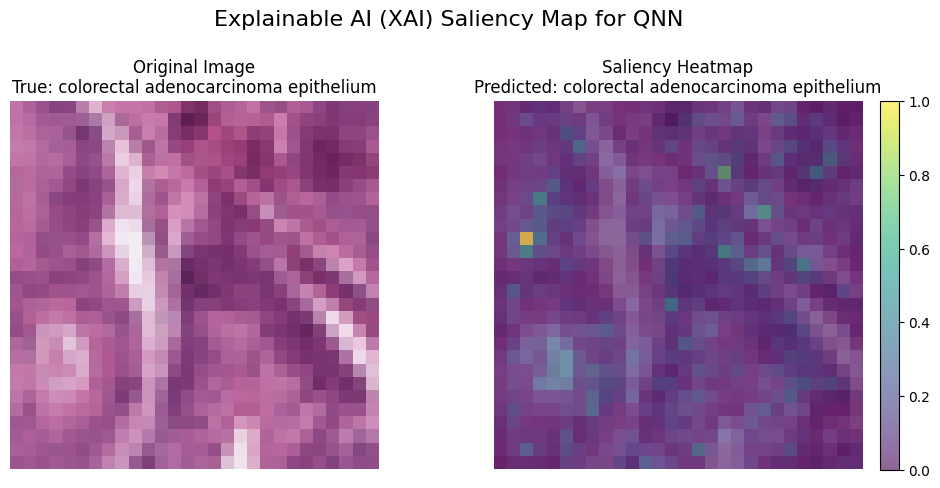

In [6]:
# Snippet 6: Visualization

# --- 1. Normalize the Saliency Map for better visualization ---
# We can apply a light blur to make the heatmap smoother
from scipy.ndimage import gaussian_filter
saliency_map_smoothed = gaussian_filter(saliency_map, sigma=0.5)

# Normalize to the range 0-1
saliency_map_normalized = (saliency_map_smoothed - saliency_map_smoothed.min()) / (saliency_map_smoothed.max() - saliency_map_smoothed.min())

# --- 2. Plot the Original Image and the Saliency Heatmap ---

# Recall the un-normalized image from Snippet 4
# un_normalized_img = image_to_test.squeeze().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
# un_normalized_img = np.clip(un_normalized_img, 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axes[0].imshow(un_normalized_img)
axes[0].set_title(f"Original Image\nTrue: {class_names[str(true_label_idx)]}")
axes[0].axis('off')

# Plot the original image with the saliency map overlay
axes[1].imshow(un_normalized_img)
im = axes[1].imshow(saliency_map_normalized, cmap='viridis', alpha=0.6) # Overlay with transparency
axes[1].set_title(f"Saliency Heatmap\nPredicted: {class_names[str(pred_label_idx)]}")
axes[1].axis('off')

# Add a colorbar to indicate importance
fig.colorbar(im, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

plt.suptitle("Explainable AI (XAI) Saliency Map for QNN", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Generating SmoothGrad saliency map...
SmoothGrad map generated successfully.


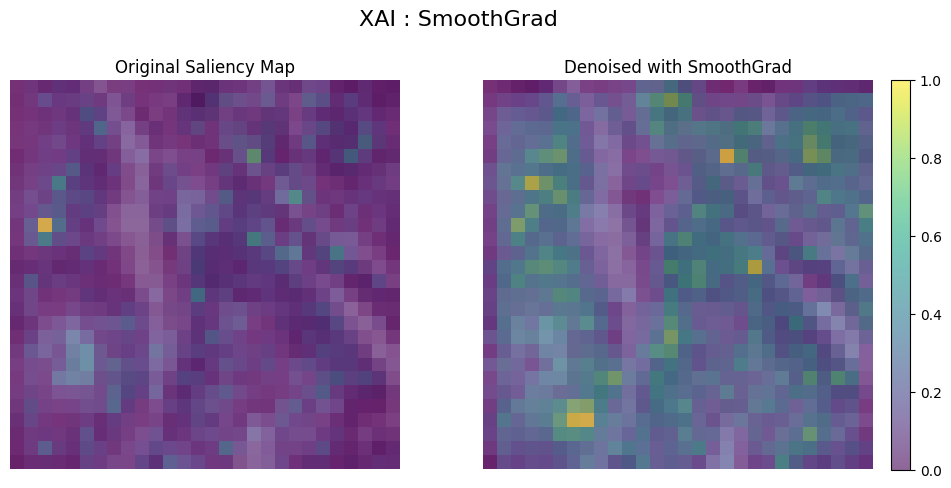

In [7]:
# Snippet 7: Denoising with SmoothGrad

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def generate_smoothgrad(model, input_tensor, target_class_idx, n_samples=25, noise_std_dev=0.1):
    """
    Generates a SmoothGrad saliency map by averaging gradients over noisy image samples.
    """
    # Detach the input tensor to prevent graph pollution during the loop
    input_tensor = input_tensor.detach()

    # Initialize a tensor to accumulate gradients
    smooth_grad = torch.zeros_like(input_tensor.squeeze(0))

    for _ in range(n_samples):
        # Create a noisy version of the input
        noise = torch.randn_like(input_tensor) * noise_std_dev
        noisy_input = (input_tensor + noise).requires_grad_(True)

        # Get model output
        model.zero_grad()
        logits = model(noisy_input)
        score = logits[0, target_class_idx]

        # Calculate gradients
        score.backward()

        # Accumulate the absolute gradients
        smooth_grad += noisy_input.grad.data.abs().squeeze(0)

    # Average the accumulated gradients
    smooth_grad /= n_samples

    return smooth_grad.cpu().numpy()

# --- Generate the SmoothGrad Map ---
print("Generating SmoothGrad saliency map...")
# Use the image and predicted label from our previous steps
smooth_grad_raw = generate_smoothgrad(model, image_to_test, pred_label_idx)

# To get a single value per pixel, take the max across color channels
smooth_saliency_map, _ = torch.max(torch.from_numpy(smooth_grad_raw), dim=0)
smooth_saliency_map = smooth_saliency_map.numpy()
print("SmoothGrad map generated successfully.")


# --- Visualize the Comparison ---
# Normalize the new map
smooth_saliency_map_smoothed = gaussian_filter(smooth_saliency_map, sigma=0.5)
smooth_saliency_map_normalized = (smooth_saliency_map_smoothed - smooth_saliency_map_smoothed.min()) / \
                                 (smooth_saliency_map_smoothed.max() - smooth_saliency_map_smoothed.min())

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle("XAI : SmoothGrad", fontsize=16)

# Plot the Original Saliency Map (from Snippet 6)
axes[0].imshow(un_normalized_img)
axes[0].imshow(saliency_map_normalized, cmap='viridis', alpha=0.6)
axes[0].set_title("Original Saliency Map")
axes[0].axis('off')

# Plot the new SmoothGrad Saliency Map
axes[1].imshow(un_normalized_img)
im = axes[1].imshow(smooth_saliency_map_normalized, cmap='viridis', alpha=0.6)
axes[1].set_title("Denoised with SmoothGrad")
axes[1].axis('off')

fig.colorbar(im, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Re-instantiating a clean model and loading best weights...
Model is ready.

Generating Grad-CAM heatmap...
Grad-CAM map generated successfully.


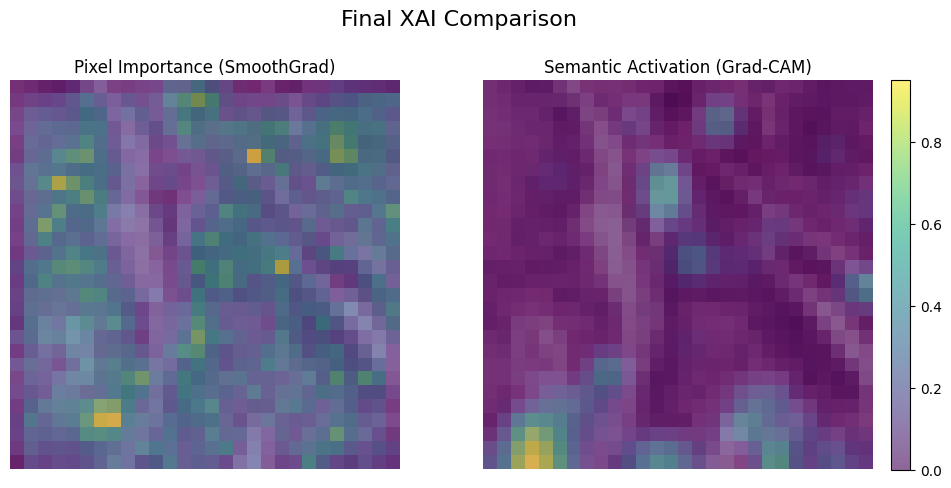

In [8]:
# Snippet 8 (Definitive Correction): Re-instantiate Model & Run Grad-CAM

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Re-instantiate a 'Clean' Model ---
# This ensures no old hooks are attached.
print("Re-instantiating a clean model and loading best weights...")
clean_model = QTFClassifier(q_feature_map=trainable_qnode,
                            weight_shapes=weight_shapes,
                            n_classes=n_classes,
                            in_channels=in_channels)
# Load the best state dictionary we saved from training
clean_model.load_state_dict(best_state)
clean_model.to(device)
clean_model.eval()
print("Model is ready.")


# --- 2. Corrected Grad-CAM Implementation ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Use the modern, full backward hook
        target_layer.register_full_backward_hook(self._backward_hook)
        self.forward_handle = target_layer.register_forward_hook(self._forward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, input_tensor, target_class_idx):
        logits = self.model(input_tensor)
        score = logits[0, target_class_idx]
        self.model.zero_grad()
        score.backward()

        # Pool gradients to get channel weights
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight activations by gradients
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        # Create heatmap
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy()

    def remove_hooks(self):
        self.forward_handle.remove()


# --- 3. Generate and Visualize ---
print("\nGenerating Grad-CAM heatmap...")
# Target the final ReLU of the CNN feature extractor (layer [4])
grad_cam = GradCAM(clean_model, target_layer=clean_model.feature_extractor[4])
grad_cam_map = grad_cam(image_to_test, pred_label_idx)
grad_cam.remove_hooks() # Clean up the hook

grad_cam_map_resized = cv2.resize(grad_cam_map, (28, 28))
print("Grad-CAM map generated successfully.")

# --- Final Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle("Final XAI Comparison", fontsize=16)

axes[0].imshow(un_normalized_img)
axes[0].imshow(smooth_saliency_map_normalized, cmap='viridis', alpha=0.6)
axes[0].set_title("Pixel Importance (SmoothGrad)")
axes[0].axis('off')

axes[1].imshow(un_normalized_img)
im = axes[1].imshow(grad_cam_map_resized, cmap='viridis', alpha=0.6)
axes[1].set_title("Semantic Activation (Grad-CAM)")
axes[1].axis('off')

fig.colorbar(im, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()